In [ ]:
 #-*- coding: utf-8 -*-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/StatisticalLearningTheoryTeamProject

/content/drive/.shortcut-targets-by-id/1laojbhC7wFZCdac_KFAAlw6158K2SdSA/StatisticalLearningTheoryTeamProject


In [ ]:
import torch
import random
import numpy as np
import pandas as pd
import os

# # 시드값 고정
# seed = 50
# os.environ['PYTHONHASHSEED'] = str(seed)
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.enabled = False

In [ ]:
# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content/drive/.shortcut-targets-by-id/1laojbhC7wFZCdac_KFAAlw6158K2SdSA/StatisticalLearningTheoryTeamProject


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [ ]:

# 데이터 경로
data_path = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/'

train = pd.read_csv(data_path + 'train_source.csv')
valid = pd.read_csv(data_path + 'val_source.csv')
test = pd.read_csv(data_path + 'test_source.csv')

train.head()


,filename,width,height,class,xmin,ymin,xmax,ymax
0,nasal_discharge_00000752_jpg.rf.85793634f22462...,300,300,nasal_discharge,53,108,87,148
1,conjunctival_injection_or_redness_00000867_jpg...,300,300,conjunctival_injection_or_redness,127,119,161,167
2,circular_alopecia_00000268_jpg.rf.85869ce3b855...,296,296,circular_alopecia,107,78,145,145
3,nasal_discharge_00000267_jpg.rf.858e63af6a0e91...,300,300,nasal_discharge,56,152,145,216
4,skin_lesions_00000917_jpg.rf.859254a3e97cd5fb6...,300,300,skin_lesions,158,150,299,277


In [ ]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir, transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        # 전달받은 인수 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)

    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]             # 이미지 ID
        img_path = self.img_dir + img_id  # 2. 이미지 파일 경로
        image = cv2.imread(img_path)  # 이미지 파일 읽기
        if image is None:
            print("이미지 로드 오류")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        # 이미지 변환
        if self.transform is not None:
            image = self.transform(image=image)['image']  # 3.
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환
        if self.is_test:
            return image # 5. 테스트용일 때
        else:
            label_idx = self.df.iloc[idx, 3] # 레이블 인덱스 반환
            if label_idx is None:
              print("label 오류")
              return None
            label_mapping = {"circular_alopecia": 0, "keratosis": 1, "skin_lesions": 2, "nasal_discharge": 3, "ocular_discharge": 4, "conjunctival_injection_or_redness": 5}
            label = label_mapping[label_idx] # 0~5 사이의 정수로 변환해서 label에 부과
            return image, label # 훈련/검증용일 때

In [ ]:
# import matplotlib.pyplot as plt

# image = cv2.imread(img_path)

# image.dtype

# plt.imshow(image)
# plt.show()

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(300, 300),       # 1. 이미지 크기 조절
    # A.RandomBrightnessContrast(brightness_limit=0.2, # 2. 밝기 대비 조절
    #                            contrast_limit=0.2, p=0.3),
    # A.VerticalFlip(p = 0.2),    # 상하 대칭 변환
    # A.HorizontalFlip(p = 0.5),  # 좌우 대칭 변환
    # A.ShiftScaleRotate(       # 3. 이동, 스케일링, 회전 변환
    #     shift_limit = 0.1,
    #     scale_limit = 0.2,
    #     rotate_limit = 30, p = 0.3),
    # A.OneOf([A.Emboss(p = 1),   # 4. 양각화, 날카로움, 블러 효과
    #          A.Sharpen(p = 1),
    #          A.Blur(p = 1)], p = 0.3),
    # A.PiecewiseAffine(p = 0.3), # 5. 어파인 변환
    A.Normalize(),            # 6. 정규화 변환
    ToTensorV2()              # 7. 텐서로 변환
])

In [ ]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(300, 300), # 이미지 크기 조절
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

In [ ]:
train_img_dir = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/train/'
val_img_dir = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/valid/'
test_img_dir = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/test/'


dataset_train = ImageDataset(train, img_dir=train_img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=val_img_dir, transform=transform_test)
dataset_test = ImageDataset(test, img_dir=test_img_dir, transform=transform_test)


In [ ]:
def seed_worker(worker_id):   #데이터 로더 시드값 고정 함수
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()  # 제너레이터 생성
g.manual_seed(0)  # 제너레이터 시드값 고정

In [ ]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 64

loader_train = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a4fb0b4aabecd9d46c23a766083b707b7360c3a99c5db4c662ca60d6c726c1ac
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

In [ ]:
# 사전 훈련된 efficientnet-b0 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

model = model.to(device) # 장비 할당

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 149MB/s] 


Loaded pretrained weights for efficientnet-b0


In [ ]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss()

In [ ]:
# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대

train_losses = []
val_losses = []

epochs = 10

# 총 에폭만큼 반복
for epoch in range(epochs):
    # <훈련>
    model.train()        # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)

    # '반복 횟수'만큼 반복
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)

        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item()
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    train_losses.append(epoch_train_loss/len(loader_train))

    # <검증>
    model.eval()          # 모델을 평가 상태로 설정
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in tqdm(loader_valid):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()

            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(6)[labels].cpu().numpy()
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실 값 : {epoch_valid_loss/len(loader_valid):.4f}')
    val_losses.append(epoch_valid_loss/len(loader_valid))

  0%|          | 0/225 [00:00<?, ?it/s]

에폭 [1/10] - 훈련 데이터 손실값 : 0.0316


  0%|          | 0/22 [00:00<?, ?it/s]

에폭 [1/10] - 검증 데이터 손실 값 : 0.0161


  0%|          | 0/225 [00:00<?, ?it/s]

에폭 [2/10] - 훈련 데이터 손실값 : 0.0128


  0%|          | 0/22 [00:00<?, ?it/s]

에폭 [2/10] - 검증 데이터 손실 값 : 0.0168


  0%|          | 0/225 [00:00<?, ?it/s]

에폭 [3/10] - 훈련 데이터 손실값 : 0.0071


  0%|          | 0/22 [00:00<?, ?it/s]

에폭 [3/10] - 검증 데이터 손실 값 : 0.0119


  0%|          | 0/225 [00:00<?, ?it/s]

에폭 [4/10] - 훈련 데이터 손실값 : 0.0043


  0%|          | 0/22 [00:00<?, ?it/s]

에폭 [4/10] - 검증 데이터 손실 값 : 0.0134


  0%|          | 0/225 [00:00<?, ?it/s]

에폭 [5/10] - 훈련 데이터 손실값 : 0.0032


  0%|          | 0/22 [00:00<?, ?it/s]

에폭 [5/10] - 검증 데이터 손실 값 : 0.0179


  0%|          | 0/225 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1laojbhC7wFZCdac_KFAAlw6158K2SdSA/StatisticalLearningTheoryTeamProject'

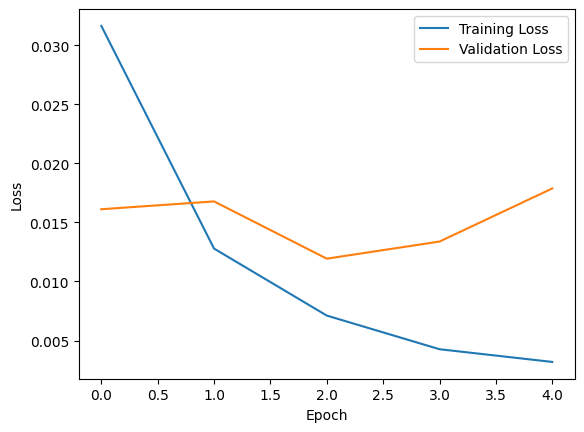

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('EfficientNet_loss_graph.png')

In [ ]:
loader_test = DataLoader(dataset_test, batch_size=batch_size,
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [ ]:
true_labels = []

label_idx = test['class']
for i in label_idx:
    label_mapping = {"circular_alopecia": 0, "keratosis": 1, "skin_lesions": 2, "nasal_discharge": 3, "ocular_discharge": 4, "conjunctival_injection_or_redness": 5}
    label = label_mapping[i]
    true_labels.append(label)

true_labels = np.array(true_labels)



In [ ]:
true_labels

array([0, 1, 2, 1, 3, 4, 5, 0, 2, 2, 2, 1, 1, 4, 2, 3, 3, 3, 5, 0, 0, 0,
       0, 0, 0, 1, 1, 2, 1, 3, 4, 1, 3, 2, 2, 1, 5, 3, 4, 3, 3, 5, 0, 4,
       4, 3, 5, 5, 3, 1, 5, 1, 4, 3, 5, 3, 0, 4, 3, 2, 1, 1, 5, 0, 0, 1,
       0, 2, 3, 3, 0, 5, 2, 4, 1, 2, 1, 2, 3, 0, 0, 0, 0, 0, 2, 5, 5, 1,
       0, 4, 5, 4, 4, 0, 3, 5, 3, 1, 2, 1, 3, 4, 0, 0, 5, 5, 5, 5, 1, 1,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 5, 2, 4, 5, 4, 5, 0, 2, 5, 2, 5,
       5, 2, 2, 2, 0, 3, 4, 2, 5, 1, 5, 1, 4, 1, 1, 1, 0, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 1, 3, 0, 4, 5, 4, 5, 1, 1, 1, 2, 2, 0, 4, 1, 0, 5, 5,
       2, 2, 5, 2, 5, 2, 2, 4, 4, 4, 0, 0, 3, 4, 4, 5, 2, 0, 2, 5, 1, 0,
       3, 2, 0, 1, 5, 4, 2, 2, 1, 2, 0, 1, 4, 0, 3, 2, 4, 3, 1, 0, 5, 3,
       4, 0, 0, 0, 0, 5, 0, 1, 3, 4, 2, 4, 0, 3, 3, 4, 4, 5, 4, 4, 4, 5,
       2, 5, 3, 1, 3, 3, 1, 2, 5, 0, 2, 4, 1, 2, 4, 1, 2, 1, 4, 5, 2, 1,
       5, 4, 5, 5, 4, 0, 1, 2, 5, 1, 4, 5, 2, 4, 0, 0, 5, 3, 1, 3, 0, 5,
       2, 5, 3, 4, 5, 3, 3, 3, 3, 0, 3, 5, 4, 0, 2,

In [ ]:
model.eval() # 모델을 평가 상태로 설정

preds = np.zeros((len(test), 6)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, (images, _) in enumerate(tqdm(loader_test)):

        # 이미지를 4차원으로 변경 (batch 차원 추가)
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part
    predicted_labels = np.argmax(preds, axis=1)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# 예측값 중 가장 높은 확률의 클래스 선택
predicted_labels = np.argmax(preds, axis=1)

# 정확도 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.5f}')

# 분류 보고서 출력
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# F1 스코어 계산
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1 Score: {f1:.5f}')

Accuracy: 0.99397
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       0.99      1.00      1.00       102
           2       1.00      1.00      1.00       101
           3       0.99      0.97      0.98        90
           4       0.98      0.99      0.99       111
           5       1.00      1.00      1.00       115

    accuracy                           0.99       663
   macro avg       0.99      0.99      0.99       663
weighted avg       0.99      0.99      0.99       663

Confusion Matrix:
[[144   0   0   0   0   0]
 [  0 102   0   0   0   0]
 [  0   0 101   0   0   0]
 [  0   1   0  87   2   0]
 [  0   0   0   1 110   0]
 [  0   0   0   0   0 115]]
F1 Score: 0.99320


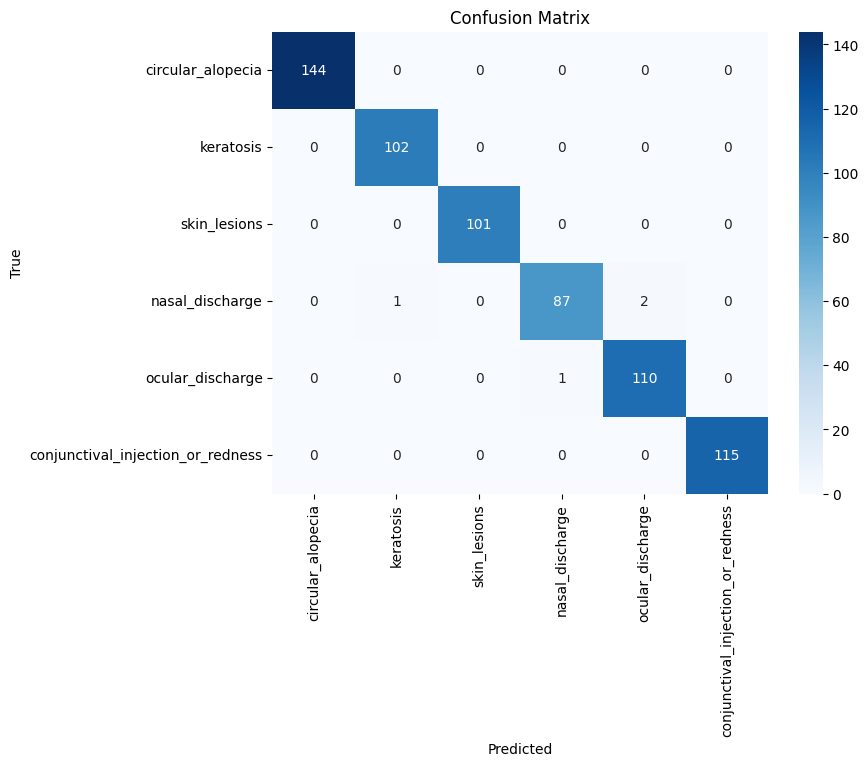

In [ ]:
import seaborn as sns

# Classification Report Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('EfficientNet_ConfusionMatrix.png')
